In [ ]:
# Here we import libraries and load data files (train and dev csv data files)

# read data
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

train_data = pd.read_csv('cw2_train.csv')
train_data

,Unnamed: 0,Sent1,Sent2,SimScore
0,0,"U.S., EU Widen Sanctions On Russia","U.S., EU Boost Sanctions On Russia",1.00
1,1,The lawyers advised the judges .,The lawyers advised the judges behind the acto...,0.79
2,2,Man kills 4 in Calif. before police shoot him ...,Police: Gunman killed 6 in California shootings,0.40
3,3,Someone is playing a piano.,A man is playing a guitar.,0.24
4,4,In an E-mail statement to the Knoxville News S...,I am not giving any consideration to resignati...,0.80
...,...,...,...,...
11493,11493,A man is playing piano.,A man is laying on the ground.,0.15
11494,11494,"The doctors resigned , or the secretaries supp...",The doctors resigned .,0.50
11495,11495,The artist contacted the banker .,The banker contacted the artist by the student .,0.29
11496,11496,"While the professors arrived , the student wai...",The professors arrived .,0.61


In [ ]:
dev_data = pd.read_csv('cw2_dev.csv')
dev_data

,Unnamed: 0,Sent1,Sent2,SimScore
0,0,A man with a hard hat is dancing.,A man wearing a hard hat is dancing.,1.00
1,1,A young child is riding a horse.,A child is riding a horse.,0.95
2,2,A man is feeding a mouse to a snake.,The man is feeding a mouse to the snake.,1.00
3,3,A woman is playing the guitar.,A man is playing guitar.,0.48
4,4,A woman is playing the flute.,A man is playing a flute.,0.55
...,...,...,...,...
2995,2995,"The professor introduced the artists , and the...",The professor introduced the artists .,0.62
2996,2996,The doctors supported the judges .,The doctors supported the tourists and the jud...,0.68
2997,2997,The secretary knew the manager .,The secretary knew the manager danced .,0.37
2998,2998,The professors next to the president recommend...,The president recommended the professors .,0.29


## Load Embeddings
We have used the Glove embeddings
for our implementation (glove.6B.200d.txt and glove.6B.100d.txt for mlp and cnn
respectively to be precise). The Glove embedding was loaded from the following link: “http://nlp.stanford.edu/data/glove.6B.zip”.

In [ ]:
## Loading glove embeddings from the link provided

!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-06-22 12:50:57--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-06-22 12:50:58--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-06-22 12:50:58--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
# Unzipping the file loaded in zip format

!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
import numpy as np

In [ ]:
'''
A function loadGloveModel is developed to load the word vectors 
from the glove embedding. Then we created the word vectors from 
the given pair of sentences (sentence-1 and sentence-2). 
'''

def loadGloveModel(File):
    print("Loading Glove Model")
    f = open(File,'r')
    gloveModel = {}
    for line in f:
        splitLines = line.split()
        word = splitLines[0]
        wordEmbedding = np.array([float(value) for value in splitLines[1:]])
        gloveModel[word] = wordEmbedding
    print(len(gloveModel)," words loaded!")
    return gloveModel

In [ ]:
word_vectors = loadGloveModel('glove.6B.100d.txt')

Loading Glove Model
400000  words loaded!


In [ ]:
## word_vec_dim was explained in the chat and
## oov_vec is used to handle the words which is not present
## in the embedding

word_vec_dim = 100
oov_vec = np.random.rand(word_vec_dim)

In [ ]:
## creates word vectors from given sentence
'''
Example: sentence = I am a student. This sentence turns into array of vectors
I = 100 dimension vector = [0.1,0.2,0.15,...]
am = 100 dimension vector = [0.8,0.3,0.11,...]
a = 100 dimension vector = [0.6,0.6,0.55,...]
student = 100 dimension vector = [0.81,0.33,0.71,...]
vecs = array of word vectors = [[0.1,0.2,0.15,...], [0.8,0.3,0.11,...], [0.6,0.6,0.55,...], [0.81,0.33,0.71,...]]
'''

def get_sent_word_vecs(word_vectors, sent_words):
    vecs = []
    for ww in sent_words:
        if ww in word_vectors:
            vecs.append(word_vectors[ww])
        else:
            vecs.append(oov_vec)
    return np.array(vecs)

## Provide Your Model
You should provide the implementaiton of your encoder model below.

In [ ]:
# define the CNN model
import torch
import torch.nn as nn

'''
This is the CNN model (three different models were developed)

A. CNN with convolution layer having the following hyper parameters: filter_size=3, strides=1 
and the linear layer having hidden layer size = 150. 

B. Here we increased the filter_size of the model (keeping other parameters fixed)
and evaluated it. CNN with convolution layer having the following hyper parameters:
filter_size=5, strides=1 and the linear layer having hidden layer size = 150. 

C. Here we increased the hidden layer size of the model (keeping other parameters
fixed) and evaluated it. CNN with convolution layer having the following hyper
parameters: filter_size=3, strides=1 and the linear layer having hidden layer size = 250. 

That is why these different parameters were used in the model
embd_dim, filter_size, stride, hidden, mat
'''

class CNN(nn.Module):
    def __init__(self, embd_dim, filter_size=3, stride=1, hidden=150, mat=4900):
        super(CNN, self).__init__()

        self.layers = nn.Sequential(
            ## Convolve layer for feature extraction
            nn.Conv1d(in_channels=1, out_channels=embd_dim, kernel_size=filter_size, stride=stride),
            ## Relu activation
            nn.ReLU(),
            ## Maxpooling
            nn.MaxPool1d(2,2),
            ## MLP layer for learning
            nn.Flatten(),
            ## Hidden layer
            nn.Linear(mat,hidden),
            ## Relu activation
            nn.ReLU(),
            ## Hidden layer
            nn.Linear(hidden, embd_dim),
            ## Relu activation
            nn.ReLU(),
        )
    
    def forward(self, sent1_vecs, sent2_vecs):
        ''' 
        For both sentence-1 and sentence-2 we are first extracting their
        mean values along row such that they are of the size (100,1) where
        100 is the word vector dimension and then sending them to CNN layers
        '''
        avg_embd1 = torch.mean(torch.FloatTensor(sent1_vecs), dim=0).unsqueeze(0)
        avg_embd2 = torch.mean(torch.FloatTensor(sent2_vecs), dim=0).unsqueeze(0)
        sent1_repr = self.layers(avg_embd1.unsqueeze(0))
        sent2_repr = self.layers(avg_embd2.unsqueeze(0))
        return sent1_repr, sent2_repr

In [ ]:
from tqdm.notebook import tqdm

'''
This entire thing is for training the model (will describe in short)
1. Converting sentences to array of word vectors
Remember example vecs = array of word vectors = [[0.1,0.2,0.15,...], [0.8,0.3,0.11,...], [0.6,0.6,0.55,...], [0.81,0.33,0.71,...]]

2. Then we compute the forward pass of the model, compute the loss value that we wish to optimize and
backpropagate the loss (basically training the sentences)

3. Lastly for each epoch we predict the cosine similarity between sentences and find the 
error value (MSE score) which later we will use for plotting the MSE score vs number of epochs
'''

def train_model(train_data, n_epochs, lr, optimizer, loss_fnc, model):
    cos_sim = nn.CosineSimilarity()
    for epoch_i in tqdm(range(n_epochs)):
        ep_loss = []
        cnt = 0
        for i, entry in tqdm(train_data.sample(frac=1).iterrows()):
            cnt += 1
            sent1 = entry['Sent1']
            sent2 = entry['Sent2']
            sent1_embds = get_sent_word_vecs(word_vectors, sent1.split())
            sent2_embds = get_sent_word_vecs(word_vectors, sent2.split())

            # Step 1: Clear the gradients 
            optimizer.zero_grad()

            # Step 2: Compute the forward pass of the model
            sent1_repr, sent2_repr = model(sent1_embds, sent2_embds)
            
            pred_sim = cos_sim(sent1_repr, sent2_repr)
            true_sim = torch.FloatTensor([entry['SimScore']])

            # Step 3: Compute the loss value that we wish to optimize
            loss = loss_fnc(pred_sim, true_sim)
            ep_loss.append(loss.detach())

            # Step 4: Propagate the loss signal backward
            loss.backward()

            # Step 5: Trigger the optimizer to perform one update
            optimizer.step()

            if  cnt%1000 == 0:
                print('epoch {}, avg loss until step {}: {}'.format(epoch_i, cnt, 0.5*np.mean(ep_loss)))

        print('\n======epoch {} loss======'.format(epoch_i),0.5*np.mean(ep_loss))

## Model-1

In [ ]:
'''
This is our model-1 with loss function, number of epochs, optimizer and learning rate and
other hyper-parameters defined
Similarly we will define 2 more models and train them
'''

model = CNN(embd_dim=word_vec_dim)
loss_fnc = nn.MSELoss()

# hyper parameters
n_epochs = 3
lr = 1e-3

# init optimizer and scheduler (lr adjustor)
import torch.optim as optim
optimizer = optim.Adam(params=model.parameters(), lr=lr) 

train_model(train_data, n_epochs, lr, optimizer, loss_fnc, model)

epoch 0, avg loss until step 1000: 0.09689973294734955
epoch 0, avg loss until step 2000: 0.08707288652658463
epoch 0, avg loss until step 3000: 0.08212670683860779
epoch 0, avg loss until step 4000: 0.07904085516929626
epoch 0, avg loss until step 5000: 0.07757464051246643
epoch 0, avg loss until step 6000: 0.07535667717456818
epoch 0, avg loss until step 7000: 0.07449199259281158
epoch 0, avg loss until step 8000: 0.07337835431098938
epoch 0, avg loss until step 9000: 0.07277568429708481
epoch 0, avg loss until step 10000: 0.07177846133708954
epoch 0, avg loss until step 11000: 0.07059135288000107


======epoch 0 loss====== 0.07002320885658264


epoch 1, avg loss until step 1000: 0.05985556170344353
epoch 1, avg loss until step 2000: 0.06279661506414413
epoch 1, avg loss until step 3000: 0.06063329428434372
epoch 1, avg loss until step 4000: 0.057937026023864746
epoch 1, avg loss until step 5000: 0.05695899575948715
epoch 1, avg loss until step 6000: 0.0563368946313858
epoch 1, avg loss until step 7000: 0.056132495403289795
epoch 1, avg loss until step 8000: 0.055685147643089294
epoch 1, avg loss until step 9000: 0.055147435516119
epoch 1, avg loss until step 10000: 0.05497853830456734
epoch 1, avg loss until step 11000: 0.054550960659980774


======epoch 1 loss====== 0.05436506122350693


epoch 2, avg loss until step 1000: 0.048886679112911224
epoch 2, avg loss until step 2000: 0.04814460128545761
epoch 2, avg loss until step 3000: 0.049366191029548645
epoch 2, avg loss until step 4000: 0.04918187856674194
epoch 2, avg loss until step 5000: 0.04841633141040802
epoch 2, avg loss until step 6000: 0.04877437278628349
epoch 2, avg loss until step 7000: 0.048775870352983475
epoch 2, avg loss until step 8000: 0.048570260405540466
epoch 2, avg loss until step 9000: 0.048496946692466736
epoch 2, avg loss until step 10000: 0.04839635640382767
epoch 2, avg loss until step 11000: 0.04813128709793091


======epoch 2 loss====== 0.048236045986413956



## Model-2

In [ ]:
model2 = CNN(embd_dim=word_vec_dim, filter_size=5, mat=4800)
loss_fnc = nn.MSELoss()

# hyper parameters
n_epochs = 3
lr = 1e-3

optimizer = optim.Adam(params=model2.parameters(), lr=lr) 
train_model(train_data, n_epochs, lr, optimizer, loss_fnc, model2)

epoch 0, avg loss until step 1000: 0.08610319346189499
epoch 0, avg loss until step 2000: 0.08271963894367218
epoch 0, avg loss until step 3000: 0.07835414260625839
epoch 0, avg loss until step 4000: 0.07682427763938904
epoch 0, avg loss until step 5000: 0.07512407004833221
epoch 0, avg loss until step 6000: 0.0739363357424736
epoch 0, avg loss until step 7000: 0.07284867763519287
epoch 0, avg loss until step 8000: 0.07138729095458984
epoch 0, avg loss until step 9000: 0.0702299028635025
epoch 0, avg loss until step 10000: 0.06961183995008469
epoch 0, avg loss until step 11000: 0.06887216866016388


======epoch 0 loss====== 0.06832917034626007


epoch 1, avg loss until step 1000: 0.05203437805175781
epoch 1, avg loss until step 2000: 0.05398938059806824
epoch 1, avg loss until step 3000: 0.05311393737792969
epoch 1, avg loss until step 4000: 0.05269757658243179
epoch 1, avg loss until step 5000: 0.052932240068912506
epoch 1, avg loss until step 6000: 0.05222133547067642
epoch 1, avg loss until step 7000: 0.051530830562114716
epoch 1, avg loss until step 8000: 0.05131068453192711
epoch 1, avg loss until step 9000: 0.05171727389097214
epoch 1, avg loss until step 10000: 0.051619935780763626
epoch 1, avg loss until step 11000: 0.051295336335897446


======epoch 1 loss====== 0.05088254436850548


epoch 2, avg loss until step 1000: 0.04305416718125343
epoch 2, avg loss until step 2000: 0.042171377688646317
epoch 2, avg loss until step 3000: 0.04267587885260582
epoch 2, avg loss until step 4000: 0.04326257482171059
epoch 2, avg loss until step 5000: 0.043379005044698715
epoch 2, avg loss until step 6000: 0.04333154857158661
epoch 2, avg loss until step 7000: 0.04385024681687355
epoch 2, avg loss until step 8000: 0.04434959590435028
epoch 2, avg loss until step 9000: 0.044571999460458755
epoch 2, avg loss until step 10000: 0.04491731524467468
epoch 2, avg loss until step 11000: 0.04481295496225357


======epoch 2 loss====== 0.04498332366347313



## Model-3

In [ ]:
model3 = CNN(embd_dim=word_vec_dim, hidden=250)
loss_fnc = nn.MSELoss()

# hyper parameters
n_epochs = 3
lr = 1e-3

optimizer = optim.Adam(params=model3.parameters(), lr=lr) 

train_model(train_data, n_epochs, lr, optimizer, loss_fnc, model3)

epoch 0, avg loss until step 1000: 0.09626864641904831
epoch 0, avg loss until step 2000: 0.08785401284694672
epoch 0, avg loss until step 3000: 0.08597651869058609
epoch 0, avg loss until step 4000: 0.08242406696081161
epoch 0, avg loss until step 5000: 0.08042319864034653
epoch 0, avg loss until step 6000: 0.07889749109745026
epoch 0, avg loss until step 7000: 0.07724909484386444
epoch 0, avg loss until step 8000: 0.07632456719875336
epoch 0, avg loss until step 9000: 0.07490601390600204
epoch 0, avg loss until step 10000: 0.07411783188581467
epoch 0, avg loss until step 11000: 0.07324427366256714


======epoch 0 loss====== 0.07230287045240402


epoch 1, avg loss until step 1000: 0.06031101942062378
epoch 1, avg loss until step 2000: 0.05850429832935333
epoch 1, avg loss until step 3000: 0.05923960357904434
epoch 1, avg loss until step 4000: 0.058053724467754364
epoch 1, avg loss until step 5000: 0.0581451952457428
epoch 1, avg loss until step 6000: 0.057748667895793915
epoch 1, avg loss until step 7000: 0.05747763440012932
epoch 1, avg loss until step 8000: 0.05729426443576813
epoch 1, avg loss until step 9000: 0.05676654353737831
epoch 1, avg loss until step 10000: 0.056649934500455856
epoch 1, avg loss until step 11000: 0.05686758831143379


======epoch 1 loss====== 0.056749001145362854


epoch 2, avg loss until step 1000: 0.05195535346865654
epoch 2, avg loss until step 2000: 0.05290638655424118
epoch 2, avg loss until step 3000: 0.05240875855088234
epoch 2, avg loss until step 4000: 0.0517728365957737
epoch 2, avg loss until step 5000: 0.050699811428785324
epoch 2, avg loss until step 6000: 0.05012846738100052
epoch 2, avg loss until step 7000: 0.0501917339861393
epoch 2, avg loss until step 8000: 0.05011647194623947
epoch 2, avg loss until step 9000: 0.05017955228686333
epoch 2, avg loss until step 10000: 0.05030253157019615
epoch 2, avg loss until step 11000: 0.04982456937432289


======epoch 2 loss====== 0.049759991466999054



## Provide Functions Needed for Evaluation
All functions used to run and evaluate your model should be provided. 

In [ ]:
import matplotlib.pyplot as plt

'''
Lastly after training what we usually do? Yes, testing
so this function is used to test our trained model
using dev csv dataset

Using this function we can check which of the 3 models
has performed the best (lowest MSE score) and will select that model
as the best model
'''

def evaluate_trained_model(trained_model, dev_data):
    pred_scores = []
    true_scores = []
    cos_sim = nn.CosineSimilarity()
    with torch.no_grad(): # let pytorch know that no gradient should be computed
        model.eval()
        for i, entry in tqdm(dev_data.iterrows()):
            sent1 = entry['Sent1']
            sent2 = entry['Sent2']
            gold_score = entry['SimScore']
            sent1_embds = get_sent_word_vecs(word_vectors, sent1.split())
            sent2_embds = get_sent_word_vecs(word_vectors, sent2.split())
            sent1_repr, sent2_repr = trained_model(sent1_embds, sent2_embds)
            pred_sim = cos_sim(sent1_repr, sent2_repr)
            pred_scores.append(pred_sim)
            true_scores.append(gold_score)

    assert len(true_scores) == len(pred_scores)
    squared_errors = [np.square(ts-ps)*0.5 for (ts, ps) in zip(true_scores, pred_scores)]
    print('MSE of the method on the dev set:', np.mean(squared_errors))

    # check the distribution (histo gram) of the squared errors
    plt.hist(squared_errors)


MSE of the method on the dev set: 0.048909698


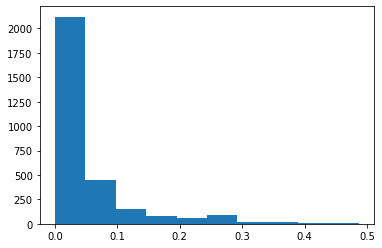

In [ ]:
evaluate_trained_model(model, dev_data)


MSE of the method on the dev set: 0.046447784


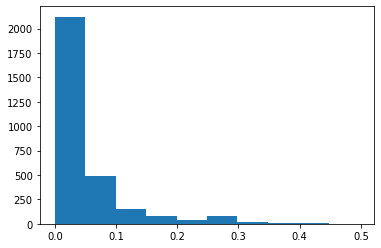

In [ ]:
evaluate_trained_model(model2, dev_data)


MSE of the method on the dev set: 0.05553697


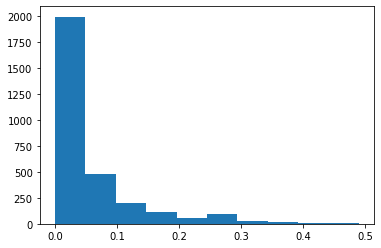

In [ ]:
evaluate_trained_model(model3, dev_data)

## Save trained model
The code below illustrates how to save the trained model. 

In [ ]:
import pickle

info_to_save = {
    'model_state_dict': model2.state_dict(),
    'oov_vec': oov_vec
}

with open('best_cnn.state_dict', 'wb') as ff:
    pickle.dump(info_to_save, ff)

## Run and Evaluate Model
The code below creates an instance of the model, loads the saved weights (sample_model.state_dict; run cw2_sample.ipynb will generate this file), and tests it.


MSE of the method on the dev set: 0.046447784


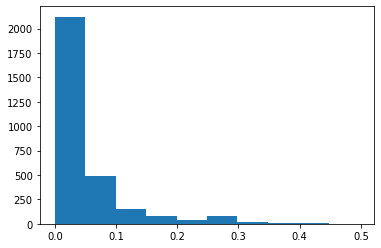

In [ ]:
import pandas as pd

dev_data = pd.read_csv('cw2_dev.csv')

# load the saved file
with open('best_cnn.state_dict','rb') as ff:
    saved_info = pickle.load(ff)

# extract the information from the saved file
oov_vec = saved_info['oov_vec']
saved_model_state = saved_info['model_state_dict']

# create model, load saved weights, and test the model
model_best = CNN(embd_dim=word_vec_dim, filter_size=5, mat=4800)
model_best.load_state_dict(saved_model_state) 
evaluate_trained_model(model_best, dev_data)